## Deep Convolutional Generative Adversarial Networks Trained on Fashion MNIST

In [1]:
# import all required packages
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and Prepare the dataset

In [2]:
(train_imgs, train_lab), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype('float32')
train_imgs = (train_imgs - 127.5) / 127.5 # Normalize the images in between -1 and 1

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [3]:
# Batch and Shuffle the data

train_set = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Define the architectures for generator and discriminator

In [6]:
# Architecture for Generator

def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) #None refers to the batch size

    # Conv2DTranspose are used to upsample for generating an image from a seed which is random noise
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = generator_model()

noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

#plt.imshow(generated_img[0,:,:,0], cmap='gray')


In [7]:
# Architecture for Discriminator Model

def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [8]:
discriminator = discriminator_model()

decision_output = discriminator(generated_img)

print(decision_output)

tf.Tensor([[0.00076952]], shape=(1, 1), dtype=float32)


### Define loss and optimizers for our model

In [9]:
# compute CrossEntropyLoss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [10]:
# Define discriminator loss

def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tot_loss = true_loss + fake_loss
    return tot_loss


In [11]:
# Define Generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
# Defining separate optimizers for generator and discriminator
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
dis_optimizer = tf.keras.optimizers.Adam(1e-4)

### Saving Checkpoints

In [20]:
checkpoints_dir = './training_chpk'
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=dis_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define number of epochs and examples to generate

In [21]:
EPOCHS = 60

noise_dim = 100
num_ex_to_gen = 16

seed = tf.random.normal([num_ex_to_gen,noise_dim])

The training begins with generator given a random seed as an input which is used to generate an image. The role of discriminator is to compare true image from training set with the fake image from generator. The loss is then calculated for both the models and weights are then updated through gradient descent. As we proceed further we will be having an efficient generator that is able to generate fake images close to the true images and an accurate discriminator that is able to accurately distinguish fake images from true images.

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_img = generator(noise, training=True)

        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)

    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))


In [23]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:
            train_step(img_batch)

        #produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 12 EPOCHS
        if (epoch + 1) % 12 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generator after final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)


### Generate and save images

In [24]:
def generate_and_save_images(model, epoch, test_input):

    # Training set to false so that every layer runs in inferenc mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


### Train model

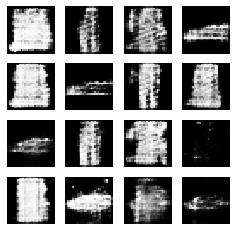

In [ ]:
%%time
train(train_set, EPOCHS)

### Restore the latest checkpoint

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir))


### Create a gif animation 

In [36]:
out_file = 'fmdcgan.gif'

with imageio.get_writer(out_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

    import IPython
    if IPython.version_info > (6,2,0,''):
        display.Image(filename=out_file)

![](fmdcgan.gif)